In [1]:
import numpy as np
import matplotlib.pylab as plt
import random as rn
import time
from scipy.spatial import ConvexHull
from matplotlib.patches import Rectangle
from matplotlib.path import Path
from mpl_toolkits.mplot3d import Axes3D
import shapely.geometry as geometry
import shapely.ops as so
from Dynamic import DynamicMap
from Camera import Camera
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from scipy.spatial import KDTree

In [2]:
# Position
map_size = [30, 30]
x0 = [5, 5, 0]
xf = [25, 5, 100]
# xf = [15, 17.5, 1000]
# static_obstacle_position: [anchor point, width, height]
static_obstacle_pos = [[[10, -5], 10, 25]]
dynamic_obstacle_pos = [[10, 20], [20, 20]]
prox = [2.5, 2.5] # [x, t]

# General RRT Settings
vmax = 10
max_time = 5

In [3]:
tilt_limit = np.array([[np.deg2rad(90), np.deg2rad(-90)], [np.deg2rad(90), np.deg2rad(-90)]]) #[upper, lower]
fov_ang = np.deg2rad(30)
fov_rng = 12
panSpeed = [-np.deg2rad(2.5), np.deg2rad(2.5)]

In [4]:
# Test case
# Vehicle Spec
vehicle = {}
vehicle['v'] = vmax
vehicle['radius'] = 0.5
t = [200, .25, 500]

# Map
map_in = {}
# Static Map
map_in['st'] = {}
map_in['st']['size'] = np.array([0, map_size[0], 0, map_size[0]])
# Single buliding example
map_in['st']['n'] = 1
map_in['st']['0'] = np.array([(static_obstacle_pos[0][0][0],static_obstacle_pos[0][0][1]), 
                              (static_obstacle_pos[0][0][0],static_obstacle_pos[0][0][1]+static_obstacle_pos[0][2]), 
                                (static_obstacle_pos[0][0][0]+static_obstacle_pos[0][1],static_obstacle_pos[0][0][1]+static_obstacle_pos[0][2]), 
                                (static_obstacle_pos[0][0][0]+static_obstacle_pos[0][1],static_obstacle_pos[0][0][1])])

# Dynamic Map
# This is a continuous function generates camera FOV coverages
# Input is map_in, and time input t_in
map_in['n'] = t[0]

# Single camera example, surveying final location xfins
# Camera Position
cam_x = np.array([dynamic_obstacle_pos[0][0], dynamic_obstacle_pos[1][0]])
cam_y = np.array([dynamic_obstacle_pos[0][1], dynamic_obstacle_pos[1][1]])
cam_dict = {}
cam_dict['n'] = len(cam_x)
map_in['ncam'] = len(cam_x)
cam_dict['x'] = cam_x
cam_dict['y'] = cam_y

# Camera Spec
cam_period = t[0]
cam_increment = t[1]
cam_dict['spec'] = {}
cam_dict['spec']['init_angle'] = [np.deg2rad(180), np.deg2rad(0)]
cam_dict['spec']['bound'] = tilt_limit
cam_dict['spec']['fov'] = [fov_ang, fov_rng]
cam_dict['spec']['cam_time'] = [cam_period, cam_increment]
cam_dict['spec']['panspeed'] = panSpeed

# Test dynamic map
dmap = DynamicMap(map_in, cam_dict)
map_in['dy'] = dmap

(0.0, 30.0)

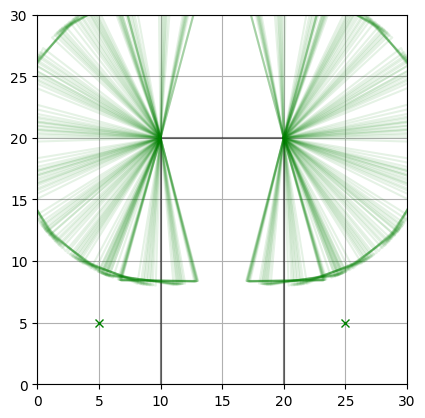

In [5]:
fig = plt.figure()
plt.plot(x0[0], x0[1], 'xg')
plt.plot(xf[0], xf[1], 'xg')

building_alpha = 0.5
for ii in range(map_in['st']['n']):
    ibuilding = map_in['st'][str(ii)]
    wall = geometry.LineString(ibuilding)
    building = geometry.Polygon(wall)
    bx,by = building.exterior.xy
    plt.plot(bx, by, '-', color='k', alpha=building_alpha)

# Plot Cameras
dmap = map_in['dy']
tvec = np.linspace(0, 100, 101)
for t in tvec:
    for ii in range(2):
        cameras = dmap.gen_cam(ii, t)
        ncam = cameras['n']
        cam_i = cameras[str(ii)]['FOV_Poly']
        cx, cy = cam_i.exterior.xy
        plt.plot(cx, cy, '-g', alpha=0.1)
plt.grid()
plt.axis('square')
# Plot Limits
plt.xlim(0, map_size[0])
plt.ylim(0, map_size[1])

2D ST-RRT*

In [6]:
def distance(a, b):
    return np.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)

In [7]:
def random_sample_test2(tf, nn, k):
    trand = rn.uniform(0, tf)
    sample_goal = rn.uniform(0, 1) < 0.1
    # Find a random point in a domain
    if sample_goal:
        # IF not, sample goal
        if np.mod(k, nn) == 0:
            xrand = xf[0]
            yrand = xf[1]
            trand = tf
        else:
            xrand = x0[0]
            yrand = x0[1]
            trand = x0[2]
    elif not sample_goal:
        # Construct Points for Convex Hull
        point1 = [x0[0], x0[2]]
        point2 = [0, x0[0]/vmax]
        point3 = [map_size[0], (map_size[0]-x0[0])/vmax]
        point4 = [0, tf-xf[0]/vmax]
        point5 = [map_size[0], tf+xf[0]/vmax-map_size[0]/vmax]
        point6 = [xf[0], tf]
        pos = [point1, point2, point3, point4, point5, point6]

        # Convex hull
        hull = ConvexHull( pos )
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((1, 2))
        for i in range(1):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        xrand = rand_points[0][0]
        trand = rand_points[0][1]
        # yrand = rn.uniform(-vmax/2*(trand - 1/vmax*(xf[0]+x0[0])), vmax/2*(trand - 1/vmax*(xf[0]+x0[0])))
        yrand = rn.uniform(np.min([0, x0[0]/vmax]), np.min([vmax*(trand+x0[0]/vmax), map_size[1]]))

    # print('xrand, trand: ', xrand, trand)
    return [xrand, yrand, trand]

In [8]:
def reachable(q0, q1, forward=True):
    dx = np.abs(q1[0]-q0[0])
    dy = np.abs(q1[1]-q0[1])
    dd = np.sqrt(dx**2 + dy**2)
    dt = q1[2]-q0[2]

    if dd == 0:
        return True
    else:
        if forward and dt > 0 and dd/dt <= vmax:
            return True
        elif not forward and dt < 0 and dd/dt <= vmax:
            return True
        return False

In [9]:
# def find_neighbor(qrand, V, n, k):
#     # Find Neighbor
#     dist_vec = []
#     if np.mod(k,n) == 0:
#         forward = True
#     else:
#         forward = False

#     for vi in V:
#         if reachable(vi, qrand, forward):
#             dist_vec.append(distance(vi, qrand))
#         else:
#             dist_vec.append(1e1000)

#     if len(dist_vec) > 0:
#         closestIndex = dist_vec.index(min(dist_vec))
#         qclosest = V[closestIndex]
#         return qclosest
#     else:
#         return None

def find_neighbor(qrand, V, n, k):
    # Find Neighbor
    dist_vec = []
    if np.mod(k,n) == 0:
        forward = True
    else:
        forward = False

    kdtree=KDTree(V)
    dist,points=kdtree.query(qrand,10)
    for ii in range(len(dist)):
        pointToCheck = V[points[ii]]
        if reachable(pointToCheck, qrand, forward):
            return pointToCheck
    return None

In [10]:
def extend(q0, q1, max_time):
    dx = q1[0]-q0[0]
    dy = q1[1]-q0[1]
    dt = q1[2]-q0[2]
    max_distance = max_time

    if np.abs(dx)<=max_distance and \
       np.abs(dy)<=max_distance and \
       np.abs(dt)<=max_time:
        qnew = q1
    else:
        norm = np.sqrt(dx**2+dy**2+dt**2)
        dxnorm = dx/norm*vmax
        dynorm = dy/norm*vmax
        dtnorm = dt/norm*vmax
        qnew = [q0[0]+dxnorm, q0[1]+dynorm, q0[2]+dtnorm]
    return qnew

In [11]:
def validate(q):
    # True:  No violation
    # False: Violation detected
    tGiven = q[2]
    qpoint = Point(q[0], q[1])

    checkInMap = []
    # Check for map
    # Check if x coordinate is OK
    if q[0] >= 0 and q[0] <= map_size[0]:
        # Check if y coordinate is OK
        if q[1] >= 0 and q[1] <= map_size[1]:
            checkInMap = False
        else:
            checkInMap = True
    else:
        checkInMap = True
    
    checkStatic = []
    # Check for static
    for i in range(len(static_obstacle_pos)):
        static_polygon = Polygon(map_in['st'][str(i)])
        checkStatic.append(static_polygon.contains(qpoint))

    checkDynamic = []
    # Check for dynamic
    for i in range(cam_dict['n']):
        cameras = dmap.gen_cam(i, tGiven)
        cam_i = cameras[str(i)]['FOV_Poly']
        checkDynamic.append(cam_i.contains(geometry.Point(q[0],q[1])))

    # print('checkInMap: ', checkInMap)
    # print('checkStatic: ', checkStatic)
    # print('checkDynamic: ', checkDynamic)
    return not (bool(checkInMap) and bool(np.sum(checkStatic)) and bool(np.sum(checkDynamic)))

In [12]:
def check_route(q1, q2):
    route_check = []
    line = geometry.LineString([q1, q2])

    checkStatic = []
    #check for static
    # False: No collision
    for i in range(len(static_obstacle_pos)):
        static_polygon = Polygon(map_in['st'][str(i)])
        checkStatic.append(line.intersects(static_polygon))

    checkDynamic = []
    # check for dynamic
    # False: No collision
    timeVectorToCheck = np.linspace(q1[2], q2[2], 101)
    for tGiven in timeVectorToCheck:
        for i in range(cam_dict['n']):
            # TODO
            # get FOV and check geometric containment
            cameras = dmap.gen_cam(i, tGiven)
            cam_i = cameras[str(i)]['FOV_Poly']
            checkDynamic.append(line.intersects(cam_i))

    # False: Collision
    # True: No Collision
    # print(bool(np.sum(checkStatic)))
    # print(bool(np.sum(checkDynamic)))
    # print(not(bool(np.sum(checkStatic))) and not(bool(np.sum(checkDynamic))))

    # True: No collision
    # False: Collison
    if not(bool(np.sum(checkStatic))) and not(bool(np.sum(checkDynamic))):
        # Collison-free
        return True
    else:
        return False


In [13]:
def find_path(qfin, E, forward=True, tf=None):
    path = []
    path.append(qfin)
    currentNode = qfin
    iter = 0
    while 1:
        # print(iter, currentNode)
        for ei in range(len(E)):
            e = E[ei][1]
            
            if currentNode[0]==e[0] and currentNode[1]==e[1] and currentNode[2]==e[2]:
                currentNode = E[ei][0]
                path.append(currentNode)
                break
        iter += 1
        if forward:
            if currentNode[0]==x0[0] and currentNode[1]==x0[1] and currentNode[2]==x0[2]:
                return path
        else:
            if currentNode[0]==xf[0] and currentNode[1]==xf[1] and currentNode[2]==tf:
                return path

In [14]:
# """Parallel RRT in 2D Space-Time"""
# time_vec = []
# RRTP_total_time = []
# RRTP_total_distance = []
# succeed_trials = 0
# iter = 0
# iter_max = 1

# compTimeLimit = 200
# # nPartition = 5
# nPartition = 10
# tf0 = 50
# tfn = 150


# while iter < iter_max:
#     print('iter: ', iter)
#     start = time.time()
#     k = 0
#     # Vertex
#     V_RRTCa = []
#     V_RRTCa.append([x0[0], x0[1], x0[2]])

#     # Time Stamp
#     T_RRTCa = []
#     T_RRTCa.append(0)
    
#     # Edge
#     E_RRTCa = []

#     tfSelection = []
#     for ii in range(nPartition):
#         tfSelection.append(rn.uniform(tf0, tfn))
    
#     V_RRTCb = {}
#     T_RRTCb = {}
#     E_RRTCb = {}
#     for ii in range(nPartition):
#         V_RRTCb[str(ii)] = []
#         V_RRTCb[str(ii)].append([xf[0], xf[1], tfSelection[ii]])
#         T_RRTCb[str(ii)] = []
#         T_RRTCb[str(ii)].append(tfSelection[ii])
#         E_RRTCb[str(ii)] = []

#     # Initial TimeUpperBound
#     path_STRRT = None
#     # while k < K:
#     qrandTime = []
#     qneighborTime = []
#     extendTime = []
#     validateTime = []
#     samplingTime = []
#     continueTime = []

#     start = time.time()
#     counter = 0
#     while 1:
#         for ii in range(nPartition):
#             currtf = tfSelection[ii]
#             # print('TimeBound: '+str(currtf)+', k: '+str(k))
#             if np.mod(k, nPartition) == 0:
#                 print('TimeBound: '+str(currtf)+', np: '+str(np.mod(k, nPartition)))
#             sampleStart = time.time()
#             while 1:
#                 qrandStart = time.time()
#                 qrand = random_sample_test2(currtf, nPartition, k)
#                 qrandTime.append(time.time()-qrandStart)
                
#                 qneighborStart = time.time()
#                 if np.mod(k,nPartition) == 0:
#                     qclosest = find_neighbor(qrand, V_RRTCa, nPartition, k)
#                 else:
#                     qclosest = find_neighbor(qrand, V_RRTCb[str(ii)], nPartition, k)
#                 qneighborTime.append(time.time()-qneighborStart)

#                 if qclosest is not None:
#                     extendStart = time.time()
#                     qnew = extend(qclosest, qrand, max_time)
#                     extendTime.append(time.time()-extendStart)

#                     # Validate
#                     validateStart = time.time()
#                     validationCheck = validate(qnew)
#                     validateTime.append(time.time()-validateStart)
#                     if validationCheck is True and check_route(qclosest, qrand) is True:
#                         break
#             samplingTime.append(time.time()-sampleStart)

#             if np.mod(k,nPartition) == 0:
#                 V_RRTCa.append(qnew)
#                 E_RRTCa.append([qclosest, qnew])
#                 T_RRTCa.append(qnew[2])
#             else:
#                 V_RRTCb[str(ii)].append(qnew)
#                 E_RRTCb[str(ii)].append([qclosest, qnew])
#                 T_RRTCb[str(ii)].append(qnew[2])

#             # Check to continue:
#             continueStart = time.time()
#             checkIfPathExist = False
#             proximity = 5
#             if np.mod(k,nPartition) == 0:
#                 for vj in V_RRTCb[str(ii)]:
#                     if distance(V_RRTCa[-1], vj) <= proximity:
#                         if reachable(V_RRTCa[-1], vj, forward=True):
#                             if check_route(V_RRTCa[-1], vj):
#                                 connectEdge = [V_RRTCa[-1], vj]
#                                 checkIfPathExist = True
#                                 succeed_trials += 1
#                                 break
#             else:
#                 for vj in V_RRTCa:
#                     if distance(vj, V_RRTCb[str(ii)][-1]) <= proximity:
#                         if reachable(V_RRTCb[str(ii)][-1], vj, forward=False):
#                             if check_route(vj, V_RRTCb[str(ii)][-1]):
#                                 connectEdge = [vj, V_RRTCb[str(ii)][-1]]
#                                 checkIfPathExist = True
#                                 succeed_trials += 1
#                                 break
#             continueTime.append(time.time()-continueStart)
#             k += 1

#             if checkIfPathExist:
#                 print('Path Found')
#                 E_STRRT = E_RRTCa + E_RRTCb[str(ii)]
#                 E_STRRT.append(connectEdge)

#                 # First segment of path
#                 print('pathRRTPa')
#                 pathRRTPa = find_path(connectEdge[0], E_RRTCa, forward=True)
#                 # pathSTRRTa.reverse()

#                 print('pathRRTPb')
#                 # Second segment of path
#                 pathRRTPb = find_path(connectEdge[1], E_RRTCb[str(ii)], forward=False, tf=tfSelection[ii])
#                 # pathSTRRTb.reverse()

#                 # Combine path into one
#                 path_RRTP = list(reversed(pathRRTPa))+pathRRTPb[1:-1]
                
#                 total_path_time = 0
#                 total_path_distance = 0
#                 for fpv in range(len(path_RRTP)-1):
#                     total_path_time+=(path_RRTP[fpv+1][2]-path_RRTP[fpv][2])
#                     total_path_distance+=distance(path_RRTP[fpv+1], path_RRTP[fpv])
#                 RRTP_total_time.append(total_path_time)
#                 RRTP_total_distance.append(total_path_distance)
#                 break
#             if time.time()-start > (compTimeLimit):
#                 break
#         if checkIfPathExist:
#             break
        
#     computationTimeDuration = time.time()-start
#     time_vec.append(computationTimeDuration)
#     iter += 1

In [19]:
"""Parallel RRT in 2D Space-Time"""
def standard_Parallel_RRT(nPartition, compTimeLimit, tf0, tfn):
    RRTP_total_time = []
    RRTP_total_distance = []

    k = 0
    # Vertex
    V_RRTCa = []
    V_RRTCa.append([x0[0], x0[1], x0[2]])

    # Time Stamp
    T_RRTCa = []
    T_RRTCa.append(0)

    # Edge
    E_RRTCa = []

    tfSelection = []
    for ii in range(nPartition):
        tfSelection.append(rn.uniform(tf0, tfn))

    V_RRTCb = {}
    T_RRTCb = {}
    E_RRTCb = {}
    for ii in range(nPartition):
        V_RRTCb[str(ii)] = []
        V_RRTCb[str(ii)].append([xf[0], xf[1], tfSelection[ii]])
        T_RRTCb[str(ii)] = []
        T_RRTCb[str(ii)].append(tfSelection[ii])
        E_RRTCb[str(ii)] = []

    start = time.time()
    while 1:
        for ii in range(nPartition):
            if time.time()-start > (compTimeLimit):
                break
            currtf = tfSelection[ii]
            print('TimeBound: '+str(currtf)+', k: '+str(k))
            while 1:
                qrand = random_sample_test2(currtf, 2, k)
                
                if np.mod(k,2) == 0:
                    qclosest = find_neighbor(qrand, V_RRTCa, 2, k)
                else:
                    qclosest = find_neighbor(qrand, V_RRTCb[str(ii)], 2, k)

                if qclosest is not None:
                    qnew = extend(qclosest, qrand, max_time)

                    # Validate
                    validationCheck = validate(qnew)
                    if validationCheck is True and check_route(qclosest, qrand) is True:
                        break

            if np.mod(k,2) == 0:
                V_RRTCa.append(qnew)
                E_RRTCa.append([qclosest, qnew])
                T_RRTCa.append(qnew[2])
            else:
                V_RRTCb[str(ii)].append(qnew)
                E_RRTCb[str(ii)].append([qclosest, qnew])
                T_RRTCb[str(ii)].append(qnew[2])
            if time.time()-start > (compTimeLimit):
                break
            # Check to continue:
            checkIfPathExist = False
            proximity = 5
            # if len(V_RRTCb[str(ii)]) > proximity and len(V_RRTCa) > proximity:
            #     if np.mod(k,2) == 0:
            #         kdtree=KDTree(V_RRTCb[str(ii)])
            #         dist,points=kdtree.query(V_RRTCa[-1],proximity)
            #         for jj in range(len(dist)):
            #             vjj = V_RRTCb[str(ii)][points[jj]]
            #             if reachable(V_RRTCa[-1], vjj, forward=True):
            #                 if check_route(V_RRTCa[-1], vjj):
            #                     connectEdge = [V_RRTCa[-1], vjj]
            #                     checkIfPathExist = True
            #                     break
            #     else:
            #         kdtree=KDTree(V_RRTCa)
            #         dist,points=kdtree.query(V_RRTCb[str(ii)][-1],proximity)
            #         for jj in range(len(dist)):
            #             vjj = V_RRTCa[points[jj]]
            #             if reachable(V_RRTCb[str(ii)][-1], vjj, forward=False):
            #                 if check_route(V_RRTCb[str(ii)][-1], vjj):
            #                     connectEdge = [V_RRTCb[str(ii)][-1], vjj]
            #                     checkIfPathExist = True
            #                     break
            # else:
            if np.mod(k,2) == 0:
                for vj in V_RRTCb[str(ii)]:
                    if distance(V_RRTCa[-1], vj) <= proximity:
                        if reachable(V_RRTCa[-1], vj, forward=True):
                            if check_route(V_RRTCa[-1], vj):
                                connectEdge = [V_RRTCa[-1], vj]
                                checkIfPathExist = True
                                break
            else:
                for vj in V_RRTCa:
                    if distance(vj, V_RRTCb[str(ii)][-1]) <= proximity:
                        if reachable(V_RRTCb[str(ii)][-1], vj, forward=False):
                            if check_route(vj, V_RRTCb[str(ii)][-1]):
                                connectEdge = [vj, V_RRTCb[str(ii)][-1]]
                                checkIfPathExist = True
                                break
            k += 1
            if time.time()-start > (compTimeLimit):
                break
            if checkIfPathExist:
                print('Path Found')
                E_RRTC = E_RRTCa + E_RRTCb[str(ii)]
                E_RRTC.append(connectEdge)

                # First segment of path
                print('pathRRTPa')
                pathRRTPa = find_path(connectEdge[0], E_RRTCa, forward=True)

                print('pathRRTPb')
                # Second segment of path
                pathRRTPb = find_path(connectEdge[1], E_RRTCb[str(ii)], forward=False, tf=tfSelection[ii])

                # Combine path into one
                path_RRTP = list(reversed(pathRRTPa))+pathRRTPb[1:-1]
                
                total_path_time = 0
                total_path_distance = 0
                for fpv in range(len(path_RRTP)-1):
                    total_path_time+=(path_RRTP[fpv+1][2]-path_RRTP[fpv][2])
                    total_path_distance+=distance(path_RRTP[fpv+1], path_RRTP[fpv])
                RRTP_total_time.append(total_path_time)
                RRTP_total_distance.append(total_path_distance)
                break
            if time.time()-start > (compTimeLimit):
                break
        if checkIfPathExist:
            break
        if time.time()-start > (compTimeLimit):
            break
    end = time.time()
    
    if checkIfPathExist:
        return True, end-start, total_path_distance, total_path_time, 1, path_RRTP, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb
    else:
        return False, end-start, 0, 0, 0, None, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb

In [20]:
pathFoundRRTP, time_RRTP, RRTP_total_distance, RRTP_total_time, success_RRTP, path_RRTP, V_RRTPa, V_RRTPb, E_RRTPa, E_RRTPb = standard_Parallel_RRT(10, 200, 100, 200)


TimeBound: 116.29932715864012, k: 0
TimeBound: 191.8460292961724, k: 1
TimeBound: 112.72323474444468, k: 2
TimeBound: 142.0149321592025, k: 3
TimeBound: 137.54755976361471, k: 4
TimeBound: 110.71457353488707, k: 5
TimeBound: 152.80779028187936, k: 6
TimeBound: 134.20629028003668, k: 7
TimeBound: 185.1980985567791, k: 8
TimeBound: 152.1478467970659, k: 9
TimeBound: 116.29932715864012, k: 10
TimeBound: 191.8460292961724, k: 11
TimeBound: 112.72323474444468, k: 12
TimeBound: 142.0149321592025, k: 13
TimeBound: 137.54755976361471, k: 14
TimeBound: 110.71457353488707, k: 15
TimeBound: 152.80779028187936, k: 16
TimeBound: 134.20629028003668, k: 17
TimeBound: 185.1980985567791, k: 18
TimeBound: 152.1478467970659, k: 19
TimeBound: 116.29932715864012, k: 20
TimeBound: 191.8460292961724, k: 21
TimeBound: 112.72323474444468, k: 22
TimeBound: 142.0149321592025, k: 23
TimeBound: 137.54755976361471, k: 24
TimeBound: 110.71457353488707, k: 25
TimeBound: 152.80779028187936, k: 26
TimeBound: 134.206290

(0.0, 30.0)

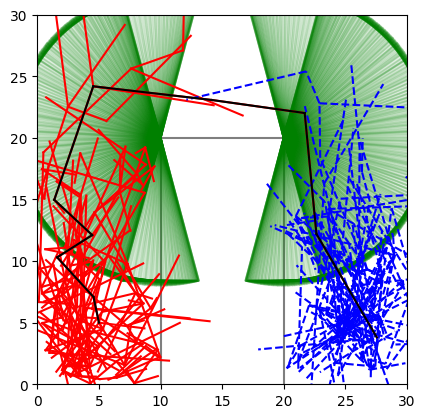

In [17]:
fig = plt.figure()

building_alpha = 0.5
for ii in range(map_in['st']['n']):
    ibuilding = map_in['st'][str(ii)]
    wall = geometry.LineString(ibuilding)
    building = geometry.Polygon(wall)
    bx,by = building.exterior.xy
    plt.plot(bx, by, '-', color='k', alpha=building_alpha)

# Plot Cameras
dmap = map_in['dy']
time_index = np.linspace(0, 150, 501)
for t in time_index:
    for ii in range(2):
        cameras = dmap.gen_cam(ii, t)
        ncam = cameras['n']
        cam_i = cameras[str(ii)]['FOV_Poly']
        cx, cy = cam_i.exterior.xy
        plt.plot(cx, cy, '-g', alpha=0.1)

for E in E_RRTPa:
    plt.plot([E[0][0], E[1][0]], [E[0][1], E[1][1]], '-r')
for ii in range(10):
    for E in E_RRTPb[str(ii)]:
        plt.plot([E[0][0], E[1][0]], [E[0][1], E[1][1]], '--b')

# plt.plot([connectEdge[0][0], connectEdge[1][0]], [connectEdge[0][1], connectEdge[1][1]], '-k')

for i in range(len(path_RRTP)-1):
    pi = path_RRTP[i]
    pj = path_RRTP[i+1]
    plt.plot([pi[0], pj[0]],[pi[1], pj[1]],'-k')

plt.axis('square')
plt.xlim(0, map_size[0])
plt.ylim(0, map_size[1])

In [18]:
# fig = plt.figure(figsize=(10, 10), dpi=500)
# ax = fig.add_subplot(111, projection='3d')
# ax.plot3D([x0[0], x0[0]], [x0[1], x0[1]], [0, 250], '--g', markersize=5)
# ax.plot3D([xf[0], xf[0]], [xf[1], xf[1]], [0, 250], '--g', markersize=5)

# building_alpha = 0.1
# for ti in time_index:
#     for ii in range(map_in['st']['n']):
#         ibuilding = map_in['st'][str(ii)]
#         wall = geometry.LineString(ibuilding)
#         building = geometry.Polygon(wall)
#         bx,by = building.exterior.xy
#         ax.plot3D(bx, by, np.ones(len(bx))*ti, '-', color='k', alpha=building_alpha)

# # Plot Cameras
# dmap = map_in['dy']
# for ti in time_index:
#     for ii in range(2):
#         cameras = dmap.gen_cam(ii, ti)
#         ncam = cameras['n']
#         cam_i = cameras[str(ii)]['FOV_Poly']
#         cx, cy = cam_i.exterior.xy
#         ax.plot3D(cx, cy, np.ones(len(cx))*ti, '-g', alpha=.2)


# for E in E_RRTCa:
#     plt.plot([E[0][0], E[1][0]], [E[0][1], E[1][1]], [E[0][2], E[1][2]], '-r')
# for ii in range(nPartition):
#     for E in E_RRTCb[str(ii)]:
#         plt.plot([E[0][0], E[1][0]], [E[0][1], E[1][1]], [E[0][2], E[1][2]], '--b')

# for i in range(len(path_RRTP)-1):
#     pi = path_RRTP[i]
#     pj = path_RRTP[i+1]
#     plt.plot([pi[0], pj[0]],[pi[1], pj[1]],[pi[2], pj[2]],'-k', linewidth=5)

# ax.view_init(elev=0., azim=-90)
